# Imports

TODO: move needed ones into utilities

In [14]:

%load_ext autoreload
%autoreload 2
from spyglass.decoding.v1.waveform_features import (
    UnitWaveformFeatures,
    WaveformFeaturesParams,
)
from spyglass.decoding.v1.clusterless import UnitWaveformFeaturesGroup


from spyglass.spikesorting.spikesorting_merge import SpikeSortingOutput
import numpy as np

import os

cur_dir = os.path.realpath(os.curdir)
cur_dir
os.chdir("/home/sambray/Documents/MS_analysis_samsplaying")
from Analysis.utils import filter_opto_data
from ms_opto_stim_protocol import OptoStimProtocol

os.chdir(cur_dir)
import matplotlib.pyplot as plt

import numpy as np
import scipy.signal


def smooth(data, n=5, sigma=None, hamming=False):
    """smooths data with gaussian kernel of size n"""
    if n % 2 == 0:
        n += 1  # make sure n is odd
    if sigma is None:
        sigma = n / 2
    kernel = gkern(n, sigma)[:, None]
    if hamming:
        n = sigma
        kernel = np.ones((sigma, 1)) / sigma
    if len(data.shape) == 1:
        pad = np.ones(((n - 1) // 2, 1))
        return np.squeeze(
            scipy.signal.convolve2d(
                np.concatenate(
                    [pad * data[:, None][0], data[:, None], pad * data[:, None][-1]],
                    axis=0,
                ),
                kernel,
                mode="valid",
            )
        )
    else:
        pad = np.ones(((n - 1) // 2, data.shape[1]))
        return scipy.signal.convolve2d(
            np.concatenate([pad * data[0], data, pad * data[-1]], axis=0),
            kernel,
            mode="valid",
        )


def gkern(l: int = 5, sig: float = 1.0):
    """
    creates gaussian kernel with side length `l` and a sigma of `sig`
    """
    ax = np.linspace(-(l - 1) / 2.0, (l - 1) / 2.0, l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    return gauss / np.sum(gauss)
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [11]:
key = {
    "nwb_file_name": "Winnie20220713_.nwb",
    "waveform_features_group_name": "10_lineartrack",
}
key = {
    "nwb_file_name": "Wallie20220912_.nwb",
    "waveform_features_group_name": "10_lineartrack",
}

waveform_keys = (UnitWaveformFeaturesGroup().UnitFeatures & key).fetch("KEY")

times_list, marks_list = (UnitWaveformFeatures & waveform_keys).fetch_data()

/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/hdmf/spe

NameError: name 'first_mark_time' is not defined

## Format and prep data for training

In [12]:
mark_times = []
marks = []

n_shanks = len(times_list)

for shank, (t, m) in enumerate(zip(times_list, marks_list)):
    mark_times.extend(t)
    # mark = np.zeros((len(t),m.shape[1],n_shanks))
    # mark[:, :, shank] = m
    # marks.extend(mark)
    mark = np.zeros((len(t), 4 + 1))
    mark[:, : m.shape[1]] = m
    mark[:, -1] = shank
    marks.extend(mark)


marks = np.array(marks)
mark_times = np.array(mark_times)
print(marks.shape, mark_times.shape)

ind = np.argsort(mark_times)
mark_times = mark_times[ind]
marks = marks[ind]

# standardize marks
marks[:, :-1] = (
    marks[:, :-1] - np.mean(marks[:, :-1], axis=1)[:, None]
)  # / np.max(np.abs(marks), axis=1)[
#     :, None, :
# ]
# standardize times
first_mark_time = mark_times[0]
mark_times = mark_times - first_mark_time
# mark_times[mark_times > 10] = 10
mark_times = mark_times * 1000
# print(np.max(np.abs(marks)))
marks[:, :-1] = marks[:, :-1] / 1000  # np.max(np.abs(marks))

(747650, 5) (747650,)


In [69]:
# load position data
key
from spyglass.common import PositionIntervalMap
from spyglass.decoding.v1.core import PositionGroup
from spyglass.position.position_merge import PositionOutput

epoch_key = {
    "nwb_file_name": key["nwb_file_name"],
    "interval_list_name": key["waveform_features_group_name"],
}
pos_interval = (PositionIntervalMap() & epoch_key).fetch1("position_interval_name")

pos_group_key = {
    "nwb_file_name": key["nwb_file_name"],
    "position_group_name": pos_interval,
}
# PositionGroup() & pos_group_key

pos_key = {
    "nwb_file_name": key["nwb_file_name"],
    "interval_list_name": pos_interval,
    "trodes_pos_params_name": "single_led_upsampled",
}
pos_merge_id = (PositionOutput.TrodesPosV1() & pos_key).fetch("merge_id")
pos_merge_key = {"pos_merge_id": pos_merge_id[0]}

from spyglass.linearization.v1 import LinearizedPositionV1

pos_df = (LinearizedPositionV1() & pos_merge_key).fetch1_dataframe()
pos_times = pos_df.index.values  # - first_mark_time
pos = pos_df.linear_position.values
vel = np.diff(pos_df.linear_position.values)
vel = np.concatenate([vel, [vel[-1]]])
vel = smooth(vel, 11, 11, hamming=True)


pos_ind = np.digitize(mark_times / 1000, pos_times) - 1
mark_pos = pos[pos_ind]
mark_vel = vel[pos_ind]

# make training vectors

In [17]:
import jax
import numpy as np

filter_position = True


# prep data for model
delta_t = np.diff(mark_times)[None, ...]
# delta_t[delta_t >10] = 10
x = marks[1:][None, ...]

ind = np.where(delta_t[0] > 0)[0]
x = x[:, ind]
marks = marks[ind]
mark_times = mark_times[ind]
delta_t = delta_t[:, ind]  # *1000

mark_pos = mark_pos[ind]
mark_vel = mark_vel[ind]


sample_length = 5000
i = sample_length
x_train = []
delta_t_train = []
if filter_position:
    valid_pos = np.logical_and(mark_pos > 20, mark_pos < 110)
else:
    valid_pos = np.ones_like(mark_pos).astype(bool)
while i < x.shape[1]:
    if np.any(delta_t[0, i - sample_length : i] > 30000):
        i += np.where(delta_t[0, i - sample_length : i] > 30000)[0][0] + 1
        continue

    if np.mean(valid_pos[i - sample_length : i]) < 0.1:
        i += sample_length // 10
        continue

    x_train.append(x[0, i - sample_length : i])
    delta_t_train.append(delta_t[0, i - sample_length : i])
    i += sample_length // 4


x_train = np.array(x_train)
delta_t_train = np.array(delta_t_train)

print(x_train.shape, delta_t_train.shape)
print(np.mean(np.sum(delta_t_train, axis=1)))

(349, 5000, 5) (349, 5000)
7805.830275090171


# Make and Train Model

In [18]:
from flax.linen import initializers
import os

initializers.lecun_normal()
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import jax

os.listdir()
# os.chdir('..')
os.chdir("/home/sambray/Documents/c3po/")
from src.c3po.model.model import C3PO

## Make Model

In [27]:
# define the model
from src.c3po.model.util import prep_training_data

keep_params = 0  # True

if keep_params:
    store_params = params.copy()
# hyperparams
# latent_dim = 16
# context_dim = 6
# encoder_widths = [32, 16, 16]  # [8, 16, 8]
latent_dim = 32
context_dim = 10
encoder_widths = [32, 64, 64]  # [8, 16, 8]


n_neg_samples = 24
shank_args = dict(encoder_model="simple", widths=encoder_widths)
encoder_args = dict(
    shank_encoder_params=shank_args,
    encoder_model="multi_shank_v1",
    n_shanks=marks.shape[-1],
    # scales=[0.9, 0.9, 0.9, 0.9],
)


# V3
dilations = [1, 2, 3, 4]
dilations = dilations * 2
kernels = [32, 32, 64, 128]
kernels = kernels * 2
context_args = dict(
    context_model="wavenet",
    layer_dilations=dilations,  # [1, 2, 3, 5, 7, 9, 17, 21, 1, 2, 3, 5, 7, 9, 17, 21],
    layer_kernel_size=kernels,
    expanded_dim=64,
    smoothing=1,
    categorical=False,
)


rate_args = dict(
    rate_model="bilinearLinear",
)

predicted_sequence_length = 5
distribution = "poisson"
sample_params = None  # "gaussian"

model = C3PO(
    encoder_args,
    context_args,
    rate_args,
    distribution,
    latent_dim,
    context_dim,
    n_neg_samples,
    predicted_sequence_length,
    sample_params=sample_params,
)

rand_key = jax.random.PRNGKey(0)
params = model.init(
    jax.random.PRNGKey(1), x_train[:3, :100], delta_t_train[:3, :100], rand_key
)
init_params = params.copy()
run_model = jax.jit(model.apply)
if keep_params:
    params = store_params.copy()
x_train.shape

x shape (3, 5)


Could not load symbol cuFuncGetName. Error: /lib/x86_64-linux-gnu/libcuda.so.1: undefined symbol: cuFuncGetName


(3, 5, 95, 32)
(3, 100, 32) (3, 5, 95, 1)
neg_z (3, 24, 100, 32)
c (3, 100, 10)
neg_params (3, 24, 95, 1)


(349, 5000, 5)

## Train Model

In [32]:
from src.c3po.model.model import loss

scale_neg_samples = 10


def change_n_neg_samples(params, x, delta_t, rand_key, n_neg_samples):
    model = C3PO(
        encoder_args,
        context_args,
        rate_args,
        distribution,
        latent_dim,
        context_dim,
        n_neg_samples,
        predicted_sequence_length,
    )
    run_model = jax.jit(model.apply)

    def training_loss_fun(params, x, delta_t, rand_key):
        pos_params, neg_params = run_model(params, x, delta_t, rand_key)
        return model.loss_generalized_model(
            pos_params,
            neg_params,
            delta_t,
            rand_key=rand_key,
            prior_params=None,
            scale_neg_samples=scale_neg_samples,
        )

    return jax.value_and_grad(training_loss_fun)


def training_loss_fun(params, x, delta_t, rand_key):
    pos_params, neg_params = run_model(params, x, delta_t, rand_key)
    return model.loss_generalized_model(
        pos_params,
        neg_params,
        delta_t,
        rand_key=rand_key,
        prior_params=None,
        scale_neg_samples=scale_neg_samples,
    )


loss_grad_fn = jax.value_and_grad(training_loss_fun)

In [68]:
from tqdm import tqdm
import optax


learning_rate = 1e-5
learning_rate = 1e-4
batch_size = 32
print(loss_grad_fn(params, x_train[:10], delta_t_train[:10], rand_key)[0])
import optax

optimizer = optax.chain(
    # optax.clip_by_global_norm(1),
    optax.adam(learning_rate),
    # optax.clip_by_block_rms(10),
    # optax.adadelta(learning_rate),
)
# Initialize parameters of the model + optimizer.
opt_state = optimizer.init(params)

n_neg = n_neg_samples
tracked_loss = []
buffer = 0
for i in range(5000):
    ind = np.arange(x_train.shape[0])
    np.random.shuffle(ind)
    epoch_loss = []
    j = 0
    with tqdm(
        total=x_train.shape[0], desc=f"Epoch {i+1}/{3000}", unit="samples"
    ) as pbar:
        prev_params = params.copy()  # store params from end of previous epoch
        while j < x_train.shape[0]:
            # Perform one gradient update.
            rand_key, _ = jax.random.split(rand_key)
            batch_inds = ind[j : j + batch_size]
            if len(batch_inds) < batch_size:
                break
            loss_val, grads = loss_grad_fn(
                params, x_train[batch_inds], delta_t_train[batch_inds], rand_key
            )
            if not np.isfinite(loss_val):
                params = prev_params.copy()
                raise ValueError("Loss is not finite")
            # print(loss_val)
            epoch_loss.append(loss_val)
            updates, opt_state = optimizer.update(grads, opt_state, params)
            params = optax.apply_updates(params, updates)
            j += batch_size

            pbar.update(batch_size)
            pbar.set_postfix(
                loss=np.mean(epoch_loss), n_neg=n_neg, batch_size=batch_size
            )
            # break
    tracked_loss.append(np.mean(epoch_loss))
    if i < 10:
        continue
    buffer -= 1
    if (np.mean(tracked_loss[-5:-1]) < tracked_loss[-1] * 1.01) and buffer <= 0:
        if n_neg < 1024:
            n_neg *= 2
            jax.clear_caches()
            del loss_grad_fn
            loss_grad_fn = change_n_neg_samples(
                params, x_train, delta_t_train, rand_key, n_neg
            )
            buffer = 5
        elif batch_size > 8:
            n_neg = 68
            batch_size = int(batch_size // 2)
            jax.clear_caches()
            del loss_grad_fn
            loss_grad_fn = change_n_neg_samples(
                params, x_train, delta_t_train, rand_key, n_neg
            )
            buffer = 5

(-11.0, 500.0)

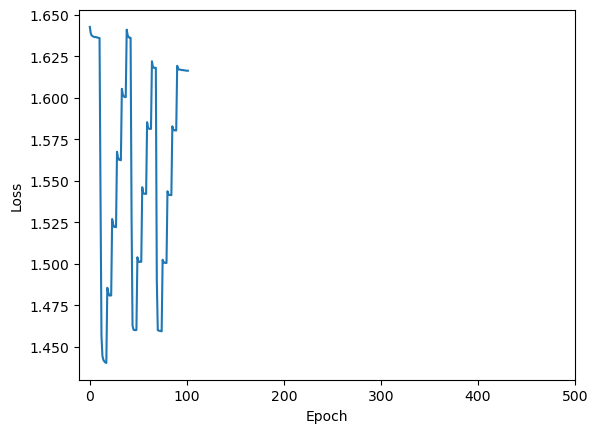

In [35]:
import matplotlib.pyplot as plt


epoch = np.arange(len(tracked_loss))
# plt.plot(epoch, tracked_loss)
plt.plot(epoch, np.log10(tracked_loss))
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.xlim(-11, 500)

# Analyze

In [126]:
from src.c3po.analysis.analysis import C3poAnalysis

model_args = dict(
    encoder_args=encoder_args,
    context_args=context_args,
    rate_args=rate_args,
    distribution=distribution,
    latent_dim=latent_dim,
    context_dim=context_dim,
    n_neg_samples=n_neg_samples,
    predicted_sequence_length=predicted_sequence_length,
    sample_params=sample_params,
)
analysis = C3poAnalysis(model=model, model_args=model_args, params=params)

In [127]:
analysis.embed_data(x, delta_t, first_mark_time)
analysis.fit_context_pca()

  0%|          | 0/725590 [00:00<?, ?it/s]

x shape (1, 5)


 96%|█████████▋| 700000/725590 [00:02<00:00, 314317.44it/s]


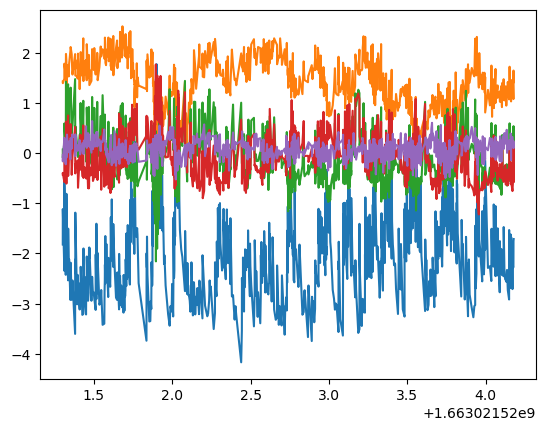

In [128]:
ind = slice(5000, 6000)
plt.plot(analysis.t[ind], analysis.c_pca[ind, :5])

# Position Coding

In [158]:
t_interp = pos_df.index.values
analysis.interpolate_context(t_interp)
analysis.embed_context_pca()
# plt.plot(analysis.c_interp[:5000])

In [159]:
running = (np.abs(vel * 500) > 10).astype(int)
st = np.where(np.diff(running) == 1)[0]
en = np.where(np.diff(running) == -1)[0]
if en[0] < st[0]:
    en = en[1:]
running_intervals = np.array(
    [[pos_df.index[s], pos_df.index[e]] for s, e in zip(st, en)]
)

In [160]:
binned_context, bins = analysis.bin_context_by_feature(
    pos_df.linear_position.values,
    pos_df.index,
    pca=True,
    valid_intervals=running_intervals,
    bins=np.linspace(10, 110, 100),
)

Text(0.5, 0, 'Linear Position (cm)')

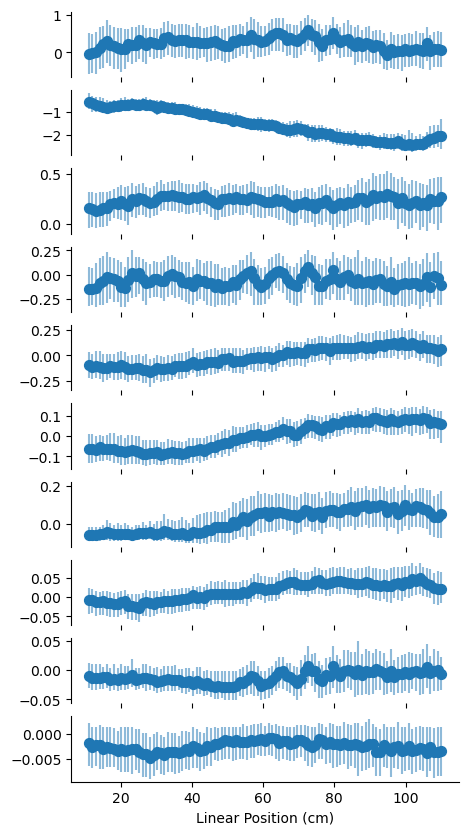

In [162]:
mid = [np.median(b, axis=0) for b in binned_context]
hi = [
    np.percentile(
        b,
        75,
        axis=0,
    )
    for b in binned_context
]
lo = [
    np.percentile(
        b,
        25,
        axis=0,
    )
    for b in binned_context
]
mid = np.array(mid)
lo = np.array(lo)
hi = np.array(hi)

fig, ax = plt.subplots(nrows=context_dim, sharex=True, figsize=(5, 10))
for i, a in enumerate(ax):
    a.scatter(bins[1:], mid[:, i], s=50)
    a.vlines(bins[1:], lo[:, i], hi[:, i], alpha=0.5)
    a.spines[["top", "right", "bottom"]].set_visible(False)
ax[-1].spines["bottom"].set_visible(True)

plt.xlabel("Linear Position (cm)")

# Theta phase analysis

### Load lfp data

In [201]:
from spyglass.lfp.analysis.v1 import LFPBandV1

os.chdir("/home/sambray/Documents/MS_analysis_samsplaying")
from Analysis.lfp_analysis import get_ref_electrode_index

os.chdir("/home/sambray/Documents/c3po")

from spyglass.common import get_electrode_indices

lfp_key = {
    "nwb_file_name": pos_key["nwb_file_name"],
    "target_interval_list_name": pos_key["interval_list_name"],
}
ref_id = get_ref_electrode_index(lfp_key)
# LFPBandV1() & lfp_key


from spyglass.lfp import LFPOutput

theta_key = {
    "nwb_file_name": pos_key["nwb_file_name"],
    "target_interval_list_name": pos_key["interval_list_name"],
    # "filter_name": "Theta 5-11 Hz",
    "filter_name": "Fast Gamma 65-100 Hz",
    # "filter_name": "Slow Gamma 25-55 Hz",
}
# LFPOutput.LFPV1() & (LFPBandV1() & theta_key).proj(merge_id = "lfp_merge_id").fetch("merge_id",as_dict=True)
exclude = (
    (LFPOutput.LFPV1() & {"lfp_electrode_group_name": "tetrode_samples"})
    .proj(lfp_merge_id="merge_id")
    .fetch("lfp_merge_id", as_dict=True)
)
query = (LFPBandV1() & theta_key) - exclude

band_obj = query.fetch_nwb()[0]["lfp_band"]
ref_ind = get_electrode_indices(band_obj, ref_id)[0]

phase_df = query.compute_signal_phase([ref_ind])
power_df = query.compute_signal_power([ref_ind])
phase_df["phase"] = phase_df.values
phase_df["power"] = power_df.values

In [211]:
t_interp = phase_df.index
analysis.interpolate_context(t_interp)
analysis.fit_context_pca(running_intervals)
analysis.embed_context_pca()

In [228]:
binned_context, bins = analysis.bin_context_by_feature(
    phase_df.phase.values,
    phase_df.index,
    pca=True,
    interpolated=True,
    valid_intervals=running_intervals,
    bins=np.linspace(0, 2 * np.pi, 30),
)

Text(0.5, 0, 'Linear Position (cm)')

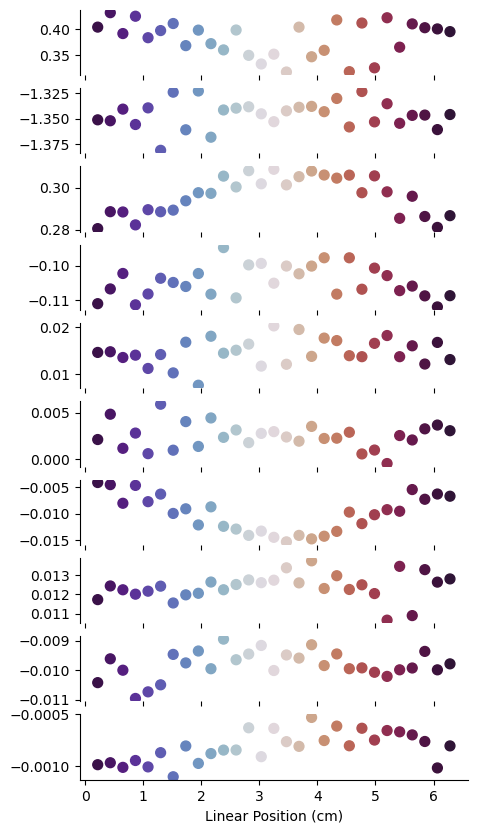

In [229]:
mid = [np.mean(b, axis=0) for b in binned_context]
hi = [
    np.percentile(
        b,
        55,
        axis=0,
    )
    for b in binned_context
]
lo = [
    np.percentile(
        b,
        45,
        axis=0,
    )
    for b in binned_context
]
mid = np.array(mid)
lo = np.array(lo)
hi = np.array(hi)

fig, ax = plt.subplots(nrows=context_dim, sharex=True, figsize=(5, 10))

c = [plt.cm.twilight_shifted(phase / (2 * np.pi)) for phase in bins[1:]]
for i, a in enumerate(ax):
    a.scatter(bins[1:], mid[:, i], s=50, c=c)
    # a.vlines(bins[1:], lo[:, i], hi[:, i], alpha=0.5)
    a.spines[["top", "right", "bottom"]].set_visible(False)
ax[-1].spines["bottom"].set_visible(True)

plt.xlabel("Linear Position (cm)")

# Sorted Spikes Response

In [281]:
from spyglass.spikesorting.analysis.v1.group import SortedSpikesGroup

spikes_key = {
    "nwb_file_name": key["nwb_file_name"],
    "sorted_spikes_group_name": key["waveform_features_group_name"],
}
spikes_list = (SortedSpikesGroup() & spikes_key).fetch_spike_data(spikes_key)

In [270]:
t_interp = np.arange(analysis.t[0], analysis.t[-1], 0.0001)
analysis.interpolate_context(t_interp)
analysis.embed_context_pca()

In [295]:
from spyglass.common import interval_list_contains
from spyglass.common import interval_list_excludes

spikes = spikes_list[12]
# spikes = spikes_list[8]
spikes = interval_list_contains(running_intervals, spikes)
# spikes = interval_list_excludes(running_intervals,spikes)

window = [-0.5, 1]

response = analysis.alligned_response(spikes, window, pca=True)

Text(0.5, 0, 'Linear Position (cm)')

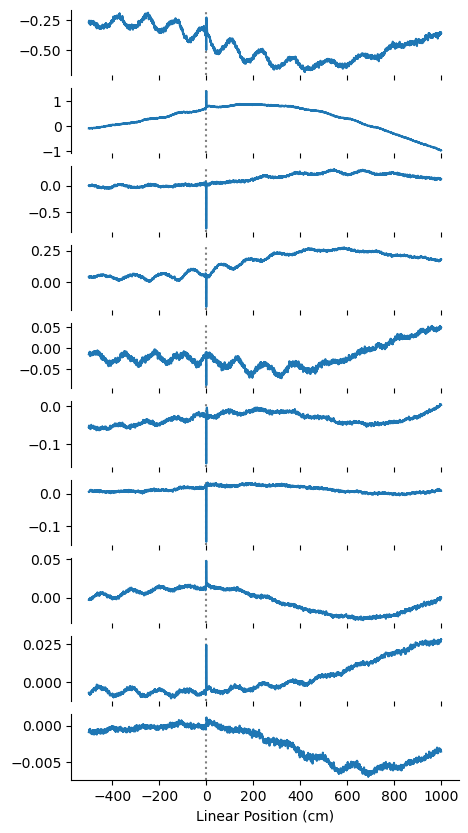

In [296]:
fig, ax = plt.subplots(nrows=context_dim, sharex=True, figsize=(5, 10))

c = [plt.cm.twilight_shifted(phase / (2 * np.pi)) for phase in bins[1:]]
t_plot = np.linspace(window[0], window[-1], response.shape[1]) * 1000
for i, a in enumerate(ax):
    a.plot(t_plot, np.mean(response[:, :, i], axis=0))
    a.axvline(0, ls=":", c="grey", zorder=-1)
    # a.vlines(bins[1:], lo[:, i], hi[:, i], alpha=0.5)
    a.spines[["top", "right", "bottom"]].set_visible(False)
ax[-1].spines["bottom"].set_visible(True)
# plt.xlim(-15,15)
plt.xlabel("Linear Position (cm)")